In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from scipy import stats


In [2]:
data = pd.read_csv("C://Users//user//Desktop//7sem//LoanApproval//again_cleaned_loan_data.csv")


In [3]:
# features and target 
X = data.drop("Loan_Status", axis=1)
y = data["Loan_Status"]


In [4]:
#Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# TreeNode 
class TreeNode:
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None


In [6]:
class DecisionTree:
    def __init__(self, max_depth=None, max_features=None, random_state=None):
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.root = None

    def fit(self, X, y):
        if isinstance(X, pd.DataFrame): X = X.values
        if isinstance(y, pd.Series): y = y.values
        self.n_classes = len(set(y))
        self.n_features = X.shape[1]
        if self.max_features is None:
            self.max_features = self.n_features
        elif isinstance(self.max_features, float):
            self.max_features = int(self.max_features * self.n_features)
        self.root = self._grow_tree(X, y, depth=0)

    def _gini(self, y):
        m = len(y)
        return 1 - sum((np.sum(y == c) / m) ** 2 for c in range(self.n_classes))

    def _best_split(self, X, y):
        best_gini = 1.0
        best_index, best_threshold = None, None
        features = random.sample(range(self.n_features), self.max_features)
        for idx in features:
            thresholds = np.unique(X[:, idx])
            for i in range(1, len(thresholds)):
                thr = (thresholds[i-1] + thresholds[i]) / 2
                left, right = y[X[:, idx] < thr], y[X[:, idx] >= thr]
                if len(left) == 0 or len(right) == 0:
                    continue
                gini = (len(left)/len(y))*self._gini(left) + (len(right)/len(y))*self._gini(right)
                if gini < best_gini:
                    best_gini = gini
                    best_index = idx
                    best_threshold = thr
        return best_index, best_threshold

    def _grow_tree(self, X, y, depth):
        class_counts = [np.sum(y == i) for i in range(self.n_classes)]
        predicted_class = np.argmax(class_counts)
        node = TreeNode(predicted_class)
        if self.max_depth is None or depth < self.max_depth:
            index, threshold = self._best_split(X, y)
            if index is not None:
                mask = X[:, index] < threshold
                node.feature_index = index
                node.threshold = threshold
                node.left = self._grow_tree(X[mask], y[mask], depth + 1)
                node.right = self._grow_tree(X[~mask], y[~mask], depth + 1)
        return node

    def _predict_single(self, x):
        node = self.root
        while node.left:
            if x[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

    def predict(self, X):
        if isinstance(X, pd.DataFrame): X = X.values
        return np.array([self._predict_single(row) for row in X])


In [7]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=None, max_features=None, subsample_size=1.0, bootstrap=True, random_state=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.subsample_size = subsample_size
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.trees = []

    def _sample(self, X, y):
        if not isinstance(X, np.ndarray): X = np.array(X)
        if not isinstance(y, np.ndarray): y = np.array(y)
        n_samples = int(len(X) * self.subsample_size)
        indices = np.random.choice(len(X), n_samples, replace=self.bootstrap)
        return X[indices], y[indices]

    def fit(self, X, y):
        self.trees = []
        for i in range(self.n_trees):
            if self.random_state is not None:
                np.random.seed(self.random_state + i)
            tree = DecisionTree(max_depth=self.max_depth, max_features=self.max_features)
            X_sample, y_sample = self._sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return stats.mode(predictions, axis=0)[0].flatten()

In [8]:
# Convert labels
y_trainData = y_train.values
y_testData = y_test.values


In [9]:
# Train Random Forest using custom Decision Tree
clf = RandomForest(n_trees=20, max_depth=5, random_state=42)
clf.fit(X_train, y_trainData)

In [10]:
# Predict
predictions = clf.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Evaluate
def evaluate_performance(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, precision, recall, f1

acc, precision, recall, f1 = evaluate_performance(y_testData, predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7805
Precision: 0.7573
Recall: 0.9750
F1 Score: 0.8525


In [12]:
import pickle

# Save the trained model
with open("loan_model.pkl", "wb") as f:
    pickle.dump(clf, f)

# Save the feature names (column order is important)
with open("features.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)


In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

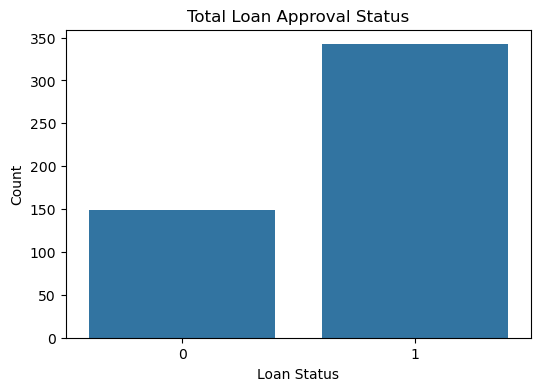

In [25]:
# 1. Total number of Yes/No loans
plt.figure(figsize=(6,4))
sns.countplot(x=y_train)
plt.title("Total Loan Approval Status")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()


Loan_Status  N  Y
Gender           
Female       1  1
Male         1  2


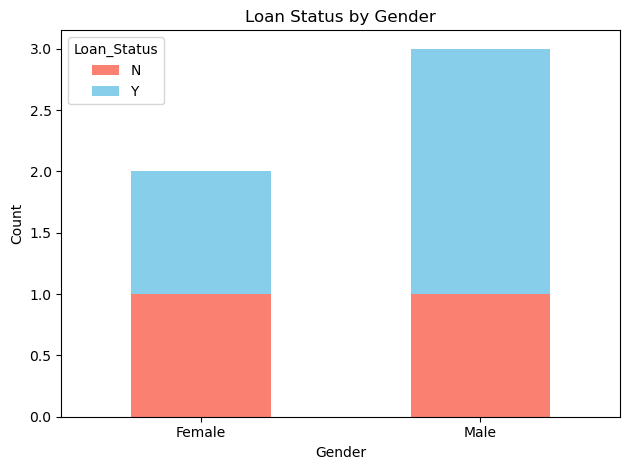

In [33]:
# Sample data
train_data = pd.DataFrame({
    "Gender": ["Male", "Female", "Male", "Female", "Male"],
    "Loan_Status": ["Y", "N", "Y", "Y", "N"]
})

# Plot total approved/denied per category
categorical_cols = ["Gender"]

for col in categorical_cols:
    summary = train_data.groupby([col, "Loan_Status"]).size().unstack(fill_value=0)
    print(summary)
    summary.plot(kind='bar', stacked=True, color=['salmon','skyblue'])
    plt.title(f"Loan Status by {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

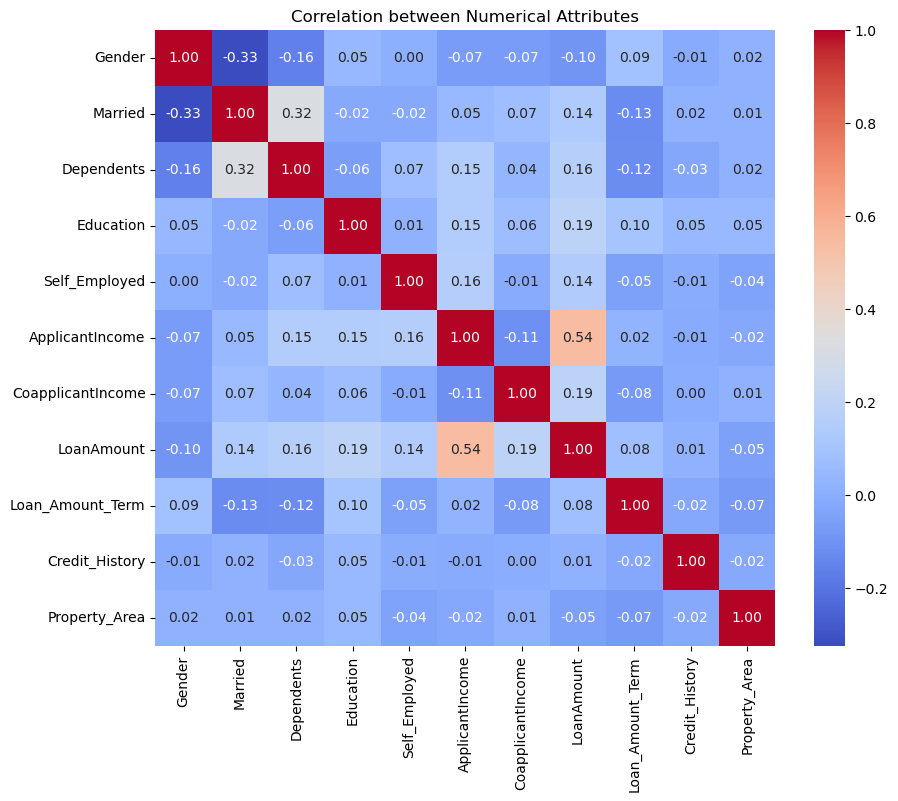

In [27]:
# 3. Correlation heatmap for numerical attributes
numerical_cols = X_train.select_dtypes(include=np.number).columns
plt.figure(figsize=(10,8))
sns.heatmap(X_train[numerical_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Numerical Attributes")
plt.show()